In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scilag

In [2]:
#Node class
class node: #hx,hy dummy vars for k, and v respectively #name must not be changed

    def __init__(self,pars): #equivalent to a constructor 
        self.update_node(pars) #list of lambdas variables that defines the node
        
        #frictional matrix: here assumes npars=2
        self.zetas=np.zeros((2,2))
        self.zetas_dhx=np.zeros((2,2))
        self.zetas_dhy=np.zeros((2,2))
        
        #derivatives
        self.dzetas_dhx=np.zeros((2,2))
        self.dzetas_dhy=np.zeros((2,2))
        
        #fits
        self.fits=np.zeros((3,2))

        
    def __str__(self): #What to print in case the class is printed
        return f"Node =[k ,v]: {self.lambt[0]}, {self.lambt[1]}"
    
    def update_node(self,lambt):
        self.lambt=lambt;
        self.hx=lambt[0]; self.hy=lambt[1]
    
    def set_params(self,params): #beta2,alpha,beta,dt,nt,verbose,nperiod):
        self.beta=params['beta']
        self.gamma=params['gamma']       
        
        #for zeta eval from cor
        self.fit_cor=True;

                
    #Compute zeta matrix from simulation
    def compute_zetas(self): #*. compute zetas from the top
        gamma,beta,k,v=self.gamma,self.beta,self.hx,self.hy
        k2=k*k; k4=k2*k2; gamma2=gamma*gamma; gamma3=gamma2*gamma;
        #*. from definition
        self.zetas[0,0]=gamma/4/k4*(k+4*beta*gamma2*v*v)
        self.zetas[1,1]=beta*gamma3/k2
        self.zetas[1,0]=-beta*v*gamma3/k2/k
        self.zetas[0,1]=self.zetas[1,0] 
   
        return    
  
        
    #=======derivative related    
    #from analytical answer
    def compute_dzeta_dlamb(self): #*. assumes zetas have already been estimated once
        gamma,beta,k,v=self.gamma,self.beta,self.hx,self.hy
    
        k2=k*k; k3=k*k2; k4=k2*k2; v2=v*v; 
        gamma2=gamma*gamma; gamma3=gamma2*gamma;
        self.dzetas_dhx[0,0] = -gamma/4/k4*(3+16*beta*gamma2*v2/k) #dk_zeta_11
        self.dzetas_dhx[1,1]= -2/k3*beta*gamma3 #dk_zeta_22
        self.dzetas_dhx[0,1]= 3/k4*beta*v*gamma3 #dk_zeta_12
        self.dzetas_dhx[1,0]=self.dzetas_dhx[0,1]
        
        self.dzetas_dhy[0,0]= 2*beta*gamma3*v/k4 #dv_zeta_11
        self.dzetas_dhy[1,1]= 0 #should already be zero and remain zero
        self.dzetas_dhy[0,1] =-beta*gamma3/k3 #dv_zeta_12
        self.dzetas_dhy[1,0]=self.dzetas_dhy[0,1]

        return

                
#end class

In [3]:
# Generic thomas method solver
class string:
    def __init__(self,nnodes,nvar_nodes,drr,T):
        self.nnodes=nnodes #size of node params
        self.nvar_nodes=nvar_nodes  #total number of string nodes
        
        #learning rate and time total (along string)
        self.drr=drr; self.T=T;
        
        #derived units        
        Nv=nnodes-2; #num of time points without fixed boundaries at end

        dt=T/(nnodes-1); #time between string points (depends on defined range of [0,T] so dt=T/(N-1))
        self.dr=drr/dt/dt; #both RHS and LHS are of order dr/dt/dt so just use effective dr

        self.nN=nvar_nodes*Nv; #total # of variables in effective variable vector (with components * # of string points)
        self.d2M=np.zeros((self.nN,self.nN)) #matrix containing the t+1 of the second derivative (LHS)
        
        #holds string vars
        self.lambt=np.zeros((nnodes*nvar_nodes))        
        
        #Construct lhs d2lambda matrix
        self.make_d2lambda(self.d2M)
        
        #speeds along strings
        self.speeds=np.zeros((self.nN));
        
        #==nodes related
        self.nodes_made=False;
        
    def __str__(self):
        print("String object with nnodes: ", nnodes)
        
    def make_d2lambda(self,d2M):
        #Fill d2M entries: i.e. the central difference of the second derivative
        # d^2\lambda/dt^2 = (lamda_{t-1}-2lambda_{t}+lambda_{t+1})/dt^2
        # This is the LHS  

        #*. Construct inner matrices
        n=self.nvar_nodes;
        mi=np.zeros((n,3*n))
        ma=np.zeros((n,2*n))
        mb=np.zeros((n,2*n))

        dr=self.dr;
        for i in range(n):
            mi[i,i]=-dr; mi[i,i+n]=1+2*dr; mi[i,i+2*n]=-dr; #inner matrix   
            ma[i,i]=1+2*dr; ma[i,i+n]=-dr; #boundary a
            mb[i,i]=-dr; mb[i,i+n]=1+2*dr;  #boundary b    

        #*. Construct block matrix
        nN=self.nN;
        for i in range(0,nN,n):
            if(i>0 and i<nN-n):
                d2M[i:i+n,(i-n)*(n-1):((i-n)*(n-1)+3*n)]=mi;
            elif(i==0):
                d2M[i:i+n,i:2*n]=ma;
            elif(i==nN-n):
                d2M[-n:,-(2*n):]=mb;

        return
        
    def get_speeds(self,lambt,speeds):
        #central difference of speed along the string
        nN=self.nN; n=self.nvar_nodes;

        for i,l in enumerate(range(0,nN,n)):
            for j in range(n):
                dotLamb_ij=(lambt[n*i+2*n+j]-lambt[n*i+j])/2 #/dt #accounted already by dr applied later

                speeds[l+j]=dotLamb_ij      
        return
    
    
    #nodes related
    def make_nodes(self,params,lamb0): #only done once
        if(self.nodes_made):
            print("!!Nodes are already created!! Nothing done.")
            return; 
            
        nN=self.nN; n=self.nvar_nodes;
        self.nodes=[] # list of nodes
        for i in range(0,nN,n): #create nodes from node class
            node_i=node(lamb0[i:i+n]);
            node_i.set_params(params);
            self.nodes.append(node_i);
        
        self.nodes_made=True #ensure it isn't done again
        
        return
    
    def update_nodes(self,lambt): #only done once
        if(not self.nodes_made):
            print("!!Nodes must be created!! Nothing done.")
            return; 
            
        nN=self.nN; n=self.nvar_nodes;
        for l, i in enumerate(range(0,nN,n)): #updates nodes from node class
            node_i=self.nodes[l]
            node_i.update_node(lambt[i:i+n])
        
        return   

    def get_rhs_b(self,lambt_all,lamb_a,lamb_b):
        #*. Get speeds
        self.get_speeds(lambt_all,self.speeds)

        #*. Get inv_zeta_gradL term
        iz_gL=self.get_inv_zeta_grad_L_long(self.speeds) # long

        #*.Compose RHS
        dr=self.dr; n=self.nvar_nodes;
        #lamb_t + dr inv_z*gradL (inv_z*gradL = longer expression contained above)
        b=lambt_all[n:-n]+dr*iz_gL

        #Adjust for fixed boundaries 
        b[:n]+=dr*lamb_a[:]
        b[-n:]+=dr*lamb_b[:]
        return b
    
    
    #=========customized functions
    #Must be customized to every individual dynamics: here assumes n=2
    def get_inv_zeta_grad_L_long(self,speeds):
        nN=self.nN; n=self.nvar_nodes;
        
        gradL_i=np.zeros((n));
        gradL_1i=np.zeros((n));
        gradL_2i=np.zeros((n));
        inv_zeta_i=np.zeros((n,n))
        iz_gL=np.zeros((nN))
        #Compute derivative from anal. experssions
        for i,l in enumerate(range(0,nN,n)):        
            ni=n*i; ni1=ni+1;
            
            #====Nodes: customized
            node_i=self.nodes[i];
            #get zeta
            node_i.compute_zetas()
            
            #===derivatives zeta from node
            node_i.compute_dzeta_dlamb()           
            
            #Grads following the long form in eq. (6) Rotskoff Vanden-Eijnden
            #grads1: d zeta_kj/dlamb_i \dot\lamb_j \dot\lamb_i
            dl1_zeta_11=node_i.dzetas_dhx[0,0];
            dl1_zeta_12=node_i.dzetas_dhx[0,1];
            dl1_zeta_22=node_i.dzetas_dhx[1,1];
            
            dl2_zeta_11=node_i.dzetas_dhy[0,0];
            dl2_zeta_12=node_i.dzetas_dhy[0,1];
            dl2_zeta_22=node_i.dzetas_dhy[1,1];
            
            gradL_1i[0]=speeds[ni]*speeds[ni]*dl1_zeta_11 + speeds[ni1]*speeds[ni1]*dl2_zeta_12\
                        +speeds[ni]*speeds[ni1]*(dl1_zeta_12+dl2_zeta_11)
            gradL_1i[1]=speeds[ni]*speeds[ni]*dl1_zeta_12 + speeds[ni1]*speeds[ni1]*dl2_zeta_22 \
                        +speeds[ni]*speeds[ni1]*(dl1_zeta_22+dl2_zeta_12) 

            #grads2 
            gradL_2i[0]=speeds[ni]*speeds[ni]*dl1_zeta_11+speeds[ni1]*speeds[ni1]*dl1_zeta_22 + \
                        2*speeds[ni]*speeds[ni1]*dl1_zeta_12
            gradL_2i[1]=speeds[ni]*speeds[ni]*dl2_zeta_11 +speeds[ni1]*speeds[ni1]*dl2_zeta_22 \
                        +2*speeds[ni]*speeds[ni1]*dl2_zeta_12    

            #sum
            gradL_i[:]=gradL_1i[:]-0.5*gradL_2i[:]; #the beta factor cancels with the beta factor from the inv zeta

            #inv zeta:invert given zeta
            inv_zeta_i=np.linalg.inv(node_i.zetas)
            
            #get mat product: 2x1 matrix result
            iz_gL[ni:ni+2]=np.matmul(inv_zeta_i,gradL_i)          
            
        return iz_gL
    
    #==========to keep segments the same============
    #String method to approximately keep lengths equal between points for a given path
    def keep_uniform(self,lambt_all_sol):
        lambt_all=np.copy(lambt_all_sol);
        x=np.asarray([lambt_all[::n],lambt_all[1::n]]) # x must be 2D
        xnew,_,_,_=self.cons_v_string(x) #return evened out string
        #convert back to lamb_all
        lambt_all[::n]=xnew[0,:]; lambt_all[1::n]=xnew[1,:];
        
        self.lambt=lambt_all[n:-n]
        return lambt_all
    
    
    def cons_v_string(self,x): # x must be 2D size (2xn)
        N=max(np.shape(x))
        def norm(x):
            return np.sqrt(np.sum(x**2))

        #*. Calculate total length of path
        dx=np.diff(x)
        Lsegs=np.sqrt(np.sum(dx**2,0))
        L=np.sum(Lsegs)

        #*. Find cumulative segment length
        Lc=np.zeros_like(Lsegs);
        for i in range(N-1):
            Lc[i]=np.sum(Lsegs[:i+1])

        #*. Recalculate points such that they fall within interpolated lines but have equal segment areas
        xnew=np.copy(x)
        Leven=L/(N-1);

        for i in range(1,N-1):
            Li=i*Leven;
            
            mask_Lc=np.where(Lc<Li)[0];
            if len(mask_Lc)>0:
                j=int(mask_Lc[-1]) # point preceding 
            else:
                j=0;
            
            k=j+1; #because dL must be such that L(k) < dL <L(k+1)  and j=k-1
            dL=Li-Lc[j]
            dx_c=dx[:,k]

            xnew[:,i]=x[:,k]+dL*dx_c/norm(dx_c)

        dxnew=np.diff(xnew)
        Lsegs_new=np.sqrt(np.sum(dxnew**2,0))

        return xnew,Leven,Lsegs,Lsegs_new #works
#end string class       

In [4]:
import time
start_time=time.time()

#========variables==================
nvar_nodes=2;  #of vars per node; 
nnodes=20; # total num. of nodes
drr=0.01; # learning rate 
T=100; #assumed time program (implicitly change dt) 
nT=400000; #number of iterations;
k1=1; k2=15; v1=2;  v2=4;

params={'beta':1e3/4.6,'gamma':0.1,'verbose':False,}
#====================================


#*. Make string
st=string(nnodes,nvar_nodes,drr,T) 
#print(st.d2M)

n=nvar_nodes;
Nv=(nnodes-2);
lambs0=np.zeros((Nv*(nvar_nodes)))
#starting conditions
lambs0[::nvar_nodes]=np.linspace(k1,k2,nnodes)[1:-1];
lambs0[1::nvar_nodes]=np.linspace(v1,v2,nnodes)[1:-1];  

st.make_nodes(params,lambs0)

lambt_all=np.zeros((nT,nnodes*(nvar_nodes)))
lambt_all[0,nvar_nodes:-nvar_nodes]=lambs0;
lamb_a=np.asarray([k1,v1]); lamb_b=np.asarray([k2,v2])
lambt_all[:,:nvar_nodes]=lamb_a
lambt_all[:,-nvar_nodes:]=lamb_b


#*. === propagation in time
for ti in range(nT-1):
    b=st.get_rhs_b(lambt_all[ti,:],lamb_a,lamb_b)
    lsol=scilag.solve(st.d2M,b) #this is the string/path for every ti    
        
    #===if segments uniform:
    #lambt_all[ti+1,n:-n]=lsol;
    #lambt_all[ti+1,:]=st.keep_uniform(lambt_all[ti+1,:]) #auto updates internall lambt

    #====if free segments    
    #update the nodes
    st.update_nodes(lsol)
    #track solutions
    lambt_all[ti+1,n:-n]=lsol;     
    
    
print("----Execution time: %s seconds ----" % (time.time() - start_time))   

----Execution time: 179.20339632034302 seconds ----


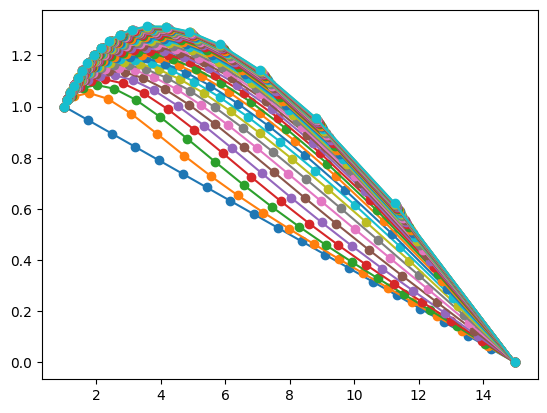

In [5]:
#plot slicing over iterations
nTstep=10000;
for i in range(0,nT,nTstep):
    plt.plot(lambt_all[i,::n],lambt_all[i,1::n],'o-')

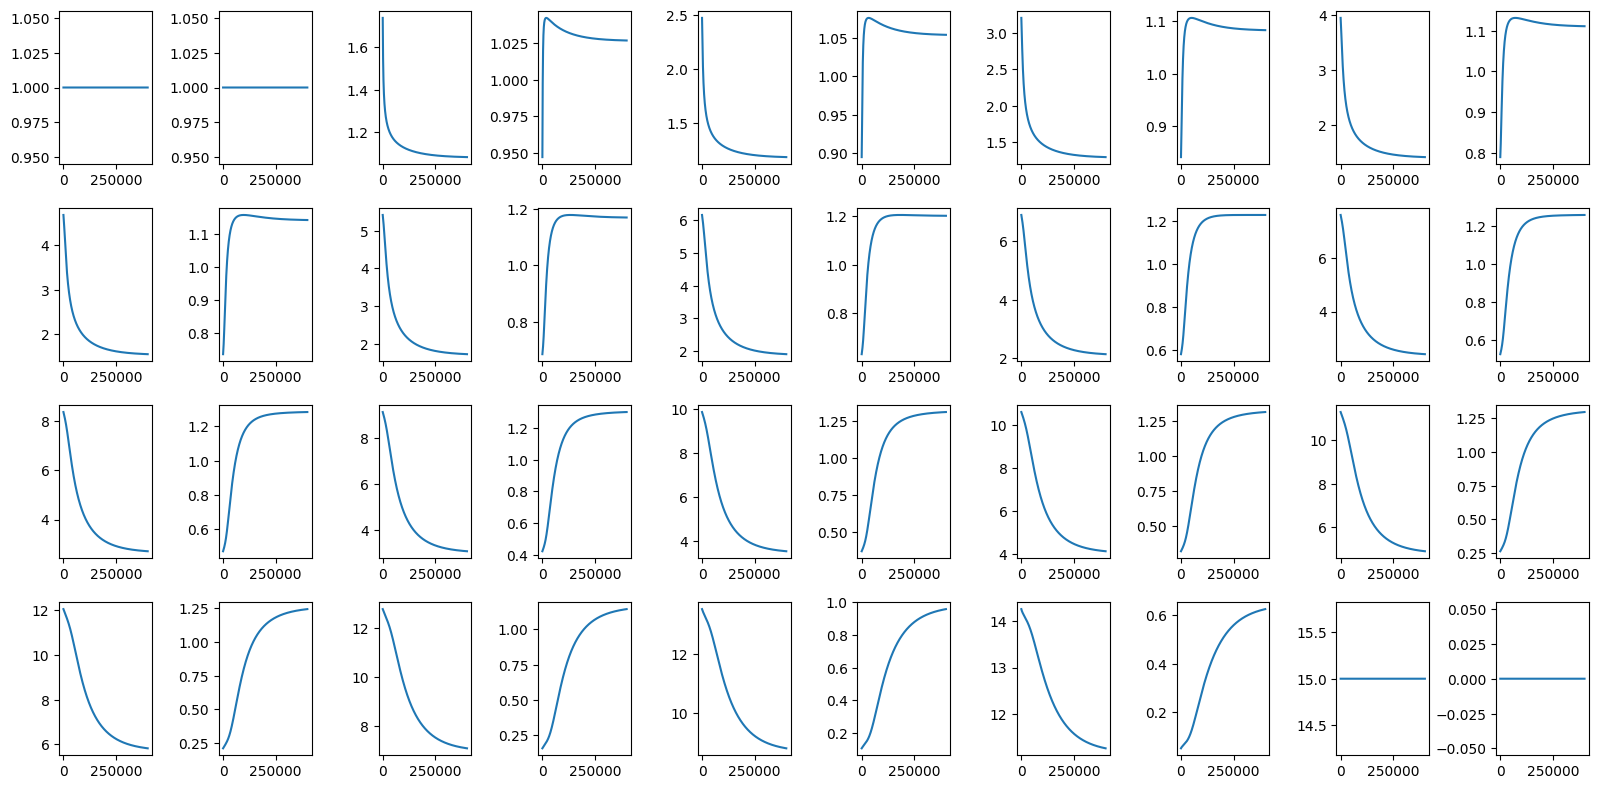

In [6]:
#*. Check convergence of variables
fig,axs=plt.subplots(4,int(nnodes/2))
fig.set_size_inches(16,8)

for i,ax in enumerate(axs.flat):
    ax.plot(lambt_all[:,i])
    #ax.set_xscale('log')
plt.tight_layout()

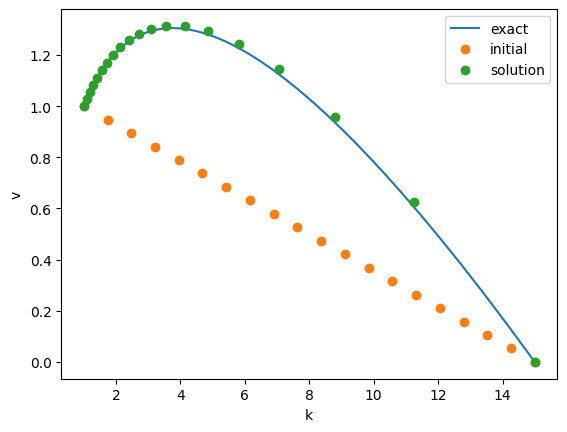

In [7]:
#Ideal scenario solved by lagrangian as per Eq. 8a-b in Sivak DeWeese, Plos one 2013
ka=k1; kb=k2;
va=v1; vb=v2;
t=np.linspace(0,T,100)/T;
k=1/(1/np.sqrt(ka)*(1-t)+1/np.sqrt(kb)*t)**2
v=k*(va/ka*(1-t)+t*vb/kb)

plt.plot(k,v,label='exact')
plt.xlabel('k'); plt.ylabel('v')
plt.plot(lambt_all[0,::n],lambt_all[0,1::n],'o',label='initial')
ti=-1
plt.plot(lambt_all[ti,::n],lambt_all[ti,1::n],'o',label='solution')
plt.legend()